In [1]:
import torch,torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from model import Generator, iterate_minibatches, compute_loss, train

In [2]:
OCTAVE_NUM = 4
NOTE_NUM = 12
TIME_SCALE = 128


class LSTM_discriminator(nn.Module):
    def __init__(self,hidden_size = 1000):
        super(self.__class__, self).__init__()
        self.hidden_size = hidden_size
        self.note_lstm = nn.LSTM(input_size = OCTAVE_NUM*3,hidden_size = hidden_size)
        self.time_lstm = nn.LSTM(input_size = hidden_size,hidden_size = hidden_size)
        self.dense = nn.Linear(hidden_size,1)

    def forward(self,data):
        # data.size() =  (batch_size, TIME_SCALE, NOTE_NUM*OCTAVE_NUM, 3)
        # octave_data.size() =  (batch_size, TIME_SCALE, NOTE_NUM,OCTAVE_NUM*3)
        batch_size,_,_,_ = data.size()
        octave_data = data.view(batch_size,TIME_SCALE,NOTE_NUM,OCTAVE_NUM,3)\
                          .view(batch_size,TIME_SCALE,NOTE_NUM,OCTAVE_NUM*3)
            
        # note_lstm_input.size() = (NOTE_NUM, batch_size*TIME_SCALE,OCTAVE_NUM*3)
        note_lstm_input = octave_data.view(batch_size*TIME_SCALE,NOTE_NUM,OCTAVE_NUM*3)\
                                     .transpose(0,1)
        # note_lstm_output.size() = (NOTE_NUM,batch_size*TIME_SCALE,hidden_size)
        note_lstm_output, _ = self.note_lstm(note_lstm_input)
        # time_lstm_input.size() = (TIME_SCALE,batch_size,hidden_size)
        time_lstm_input = note_lstm_output[-1].view(batch_size,TIME_SCALE,self.hidden_size)\
                                          .transpose(0,1)\
        # time_lstm_output.size() = (TIME_SCALE,batch_size,1000)
        time_lstm_output, _  = self.time_lstm(time_lstm_input)
        # dense_input.size() = (batch_size,1000)
        dense_input = time_lstm_output[-1]
        # dense_output.size() = (batch_size,1)
        dense_output = self.dense(dense_input)
        probs = F.sigmoid(dense_output)
        return probs
        
        
        

In [ ]:
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
discriminator = LSTM_discriminator(hidden_size=10).to(device)
np_data = np.random.randn(10,TIME_SCALE,NOTE_NUM*OCTAVE_NUM,3)
data = torch.FloatTensor(np_data).to(device)
discriminator(data)

In [ ]:
class LSTM_baseline(nn.Module):
    def __init__(self,hidden_size = 1000):
        super(self.__class__, self).__init__()
        self.hidden_size = hidden_size
        self.note_lstm = nn.LSTM(input_size = OCTAVE_NUM*3,hidden_size = hidden_size)
        self.time_lstm = nn.LSTM(input_size = hidden_size,hidden_size = hidden_size)
        self.dense = nn.Linear(hidden_size,1)

    def forward(self,data):
        # data.size() =  (batch_size, TIME_SCALE, NOTE_NUM*OCTAVE_NUM, 3)
        # octave_data.size() =  (batch_size, TIME_SCALE, NOTE_NUM,OCTAVE_NUM*3)
        batch_size,_,_,_ = data.size()
        octave_data = data.view(batch_size,TIME_SCALE,NOTE_NUM,OCTAVE_NUM,3)\
                          .view(batch_size,TIME_SCALE,NOTE_NUM,OCTAVE_NUM*3)
            
        # note_lstm_input.size() = (NOTE_NUM, batch_size*TIME_SCALE,OCTAVE_NUM*3)
        note_lstm_input = octave_data.view(batch_size*TIME_SCALE,NOTE_NUM,OCTAVE_NUM*3)\
                                     .transpose(0,1)
        # note_lstm_output.size() = (NOTE_NUM,batch_size*TIME_SCALE,hidden_size)
        note_lstm_output, _ = self.note_lstm(note_lstm_input)
        # time_lstm_input.size() = (TIME_SCALE,batch_size,hidden_size)
        time_lstm_input = note_lstm_output[-1].view(batch_size,TIME_SCALE,self.hidden_size)\
                                          .transpose(0,1)\
        # time_lstm_output.size() = (TIME_SCALE,batch_size,1000)
        time_lstm_output, _  = self.time_lstm(time_lstm_input)
        # dense_input.size() = (batch_size,1000)
        dense_input = time_lstm_output[-1]
        # dense_output.size() = (batch_size,1)
        dense_output = self.dense(dense_input)
        probs = F.sigmoid(dense_output)
        return probs

In [ ]:
discriminator = LSTM_baseline(hidden_size=1000).to(device)
np_data = np.random.randn(10,TIME_SCALE,NOTE_NUM*OCTAVE_NUM,3)
data = torch.FloatTensor(np_data).to(device)
discriminator(data)

In [4]:
class BasicGenerator(nn.Module):
    def __init__(self,hidden_size = 1000):
        super(self.__class__, self).__init__()
        self.dense_in = nn.Linear(TIME_SCALE*NOTE_NUM*OCTAVE_NUM*3,hidden_size)
        self.dense_out = nn.Linear(hidden_size,TIME_SCALE*NOTE_NUM*OCTAVE_NUM*3)

    def forward(self,data,_):
        batch_size,_,_,_ = data.size()
        data = data.view(batch_size,-1)
        hid_data = self.dense_in(data)
        out_data = self.dense_out(hid_data)
        output = F.sigmoid(out_data.view(batch_size, TIME_SCALE, NOTE_NUM*OCTAVE_NUM, 3))
        return output
        

In [5]:
class SequenceGenerator(nn.Module):
    def __init__(self,hidden_size = 10):
        super(self.__class__, self).__init__()
        self.dense_in = nn.Linear(TIME_SCALE*NOTE_NUM*OCTAVE_NUM*3,hidden_size)

    def forward(self,data,_):
        batch_size,_,_,_ = data.size()
        data = data.view(batch_size,-1)
        hid_data = self.dense_in(data)
        out_data = self.dense_out(hid_data)
        output = F.sigmoid(out_data.view(batch_size, TIME_SCALE, NOTE_NUM*OCTAVE_NUM, 3))
        return output

In [3]:
def g_loss(p_fake,sound,in_probs,eps = 1e-8):
#     probs = sound[:,TIME_SCALE//2:,:,:2]*in_probs[:,TIME_SCALE//2:,:,:2]\
#             +(1-sound[:,TIME_SCALE//2:,:,:2])*(1-in_probs[:,TIME_SCALE//2:,:,:2])
    probs = sound[:,:,:,:2]*in_probs[:,:,:,:2]\
            +(1-sound[:,:,:,:2])*(1-in_probs[:,:,:,:2])
    return ((probs+eps).log().sum(dim =-1).sum(dim =-1).sum(dim =-1)*p_fake).mean()
def d_loss(p_fake, p_true,eps = 1e-8):
     return -((1-p_fake+eps).log().mean()-(p_true+eps).log().mean())


In [10]:
import torch.utils.data

def sample_sound(data_gen):
    size = data_gen.size()
    rand = torch.rand(*size).cuda()
    sample = (rand<data_gen).type(torch.FloatTensor).cuda()
    sample[:,:,:,2] = data_gen[:,:,:,2]
    return sample
    

def train_GAN(generator,discriminator,X_loader,Y_loader,num_epochs = 3,g_lr = 0.001, d_lr = 0.001):
    generator.train()
    discriminator.train()
    g_optimizer = torch.optim.Adam(generator.parameters(),     lr=g_lr, betas=(0.5, 0.999))
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=d_lr, betas=(0.5, 0.999))
    d_losses = []
    g_losses = []
    for epoch in range(num_epochs):
        for [x_batch,ch_batch],[y_batch] in zip(X_loader,Y_loader):
            x_batch = x_batch.cuda()
            ch_batch = ch_batch.cuda()
            y_batch = y_batch.cuda()
            # Optimize D

            data_gen = generator(x_batch,ch_batch)
            sound = sample_sound(data_gen)
            #concat_sound = torch.cat([x_batch[:,1:TIME_SCALE//2+1,:,:],sound[:,TIME_SCALE//2:,:,:]],dim = 1)
            loss = d_loss(discriminator(sound), discriminator(y_batch))
            d_optimizer.zero_grad()
            loss.backward()
#             print(loss.grad)
            d_optimizer.step()
            d_losses.append(loss.data.cpu().numpy())

            # Optimize G
            
            data_gen = generator(x_batch,ch_batch)
            sound = sample_sound(data_gen)
            #concat_sound = torch.cat([x_batch[:,1:TIME_SCALE//2+1,:,:],sound[:,TIME_SCALE//2:,:,:]],dim = 1)
            loss = g_loss(discriminator(sound.data),sound.data,data_gen)
            g_optimizer.zero_grad()
            loss.backward()
#             print(loss.grad)
            g_optimizer.step()
            g_losses.append(loss.data.cpu().numpy())
    return generator,discriminator,np.array(g_losses),np.array(d_losses)

In [5]:
from dataset import load_all
from constants import *

styles= [['data/Bach']]
train_data, train_labels = load_all(styles, BATCH_SIZE, TIME_SCALE)
N = 2500
X_tr = train_data[0][:N]
y_tr = train_labels[0][:N]
X_te = train_data[0][N:2*N]
train_data[0].shape,X_te.shape,y_tr.shape,N
#y_te = train_labels[0][-1:]

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


((5727, 128, 48, 3), (2500, 128, 48, 3), (2500, 128, 48, 3), 2500)

In [6]:
X_loader = torch.utils.data.DataLoader(\
            torch.utils.data.TensorDataset(\
            *(torch.FloatTensor(X_tr),
            torch.FloatTensor(y_tr))),\
            batch_size=50,shuffle=True)
Y_loader = torch.utils.data.DataLoader(\
            torch.utils.data.TensorDataset(\
            torch.FloatTensor(X_te)),\
            batch_size=50,shuffle=True)

In [25]:
# device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
generator = Generator().cuda()
discriminator = LSTM_discriminator(hidden_size=100).cuda()
generator,discriminator,g_losses,d_losses =\
                train_GAN(generator,discriminator,X_loader,Y_loader,num_epochs = 1, g_lr = 1000,d_lr=0)

/usr/local/lib/python3.5/dist-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


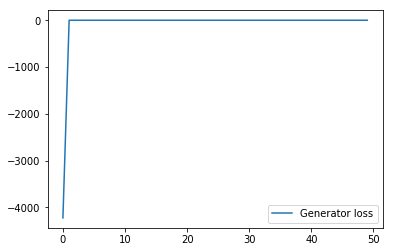

In [26]:
import matplotlib.pyplot as plt
plt.plot(g_losses,label = "Generator loss")
# plt.plot(d_losses,label = "Discriminator loss")
plt.legend()
plt.show()

In [19]:
g_losses

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [28]:
from generate import write_file, generate
write_file('output/canonical_test', generate(generator, 4,cuda = True))

  2%|▏         | 1/64 [00:00<00:06,  9.83it/s]

Generating with no styles:


/workspace/MusicGeneration/project_dnn2018/generate.py:88: RuntimeWarning: divide by zero encountered in true_divide
  x = -np.log(1 / prob - 1)
100%|██████████| 64/64 [00:06<00:00,  9.35it/s]

Writing file out/samples/output/canonical_test_0.mid
